### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import csv
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from sklearn.datasets import make_classification
from torch.utils.data import Dataset, TensorDataset, DataLoader
import lightkurve as lk
from scipy.optimize import curve_fit
import sys
import utils


/home/lzucker1/miniconda3/envs/general/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Download LC Data

In [ ]:
n_curves = 1000 - len(pd.read_csv('../Data/flux_all_5000_50.csv')) # number of curves to add to the files
n_timesteps = 5000
pct_transits = 50
downsize_method = 'interpolate'
savepath = 'Data'

utils.collect_curves_tofiles(n_curves, n_timesteps, downsize_method, pct_transits, savepath)


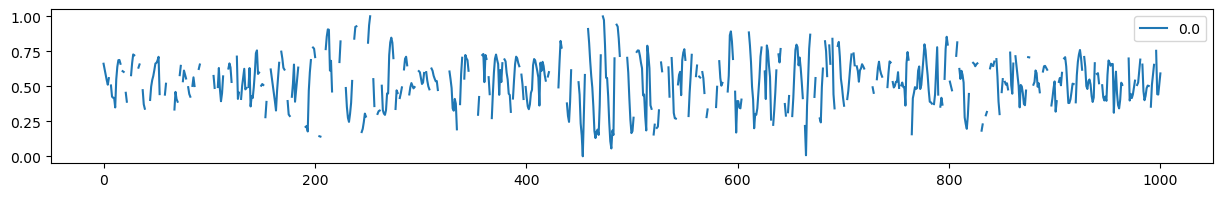

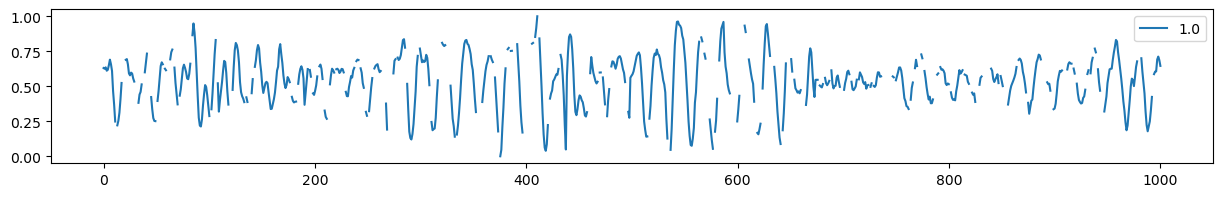

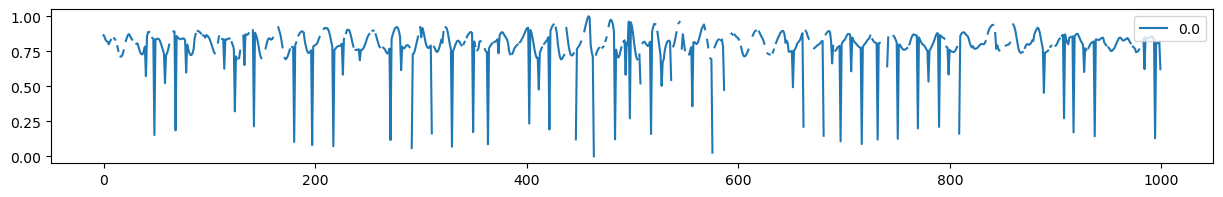

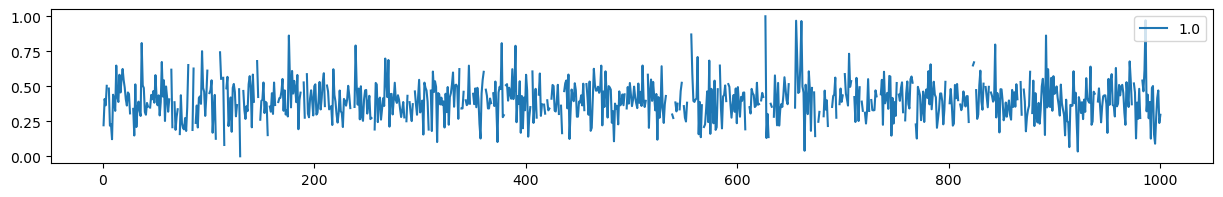

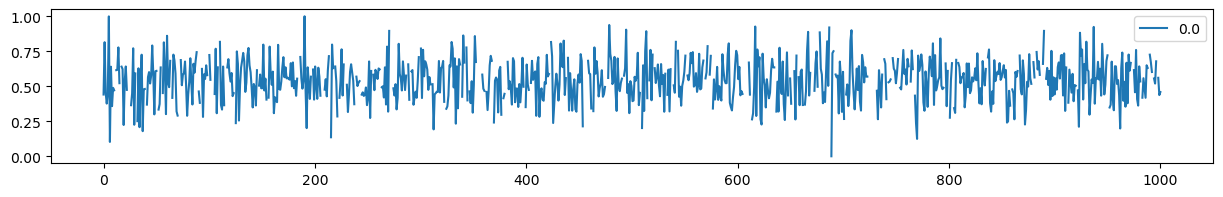

In [16]:
data = pd.read_csv(f"Data/flux_200_1000_50.csv", header=None)
labels = pd.read_csv(f"Data/labels_200_1000_50.csv", header=None)
for i in range(5):
    fluxnorm = ((data.iloc[i] - np.nanmin(data.iloc[i]))/(np.nanmax(data.iloc[i]) - np.nanmin(data.iloc[i])))
    plt.figure(figsize=(15, 2)); plt.plot(np.linspace(0, 1000, 1000), fluxnorm, label=labels.iloc[i][0]); plt.legend(loc='upper right')

### Implement NN

In [4]:
'''
Try with just normal feed-foward NN using fluxes as features
  - Why does this work so well??
'''

# Load in data and make into train and testloaders
X = pd.read_csv(f"../Data/flux_all_5000_50.csv", header=None).to_numpy() # currently 458 obs
Y = pd.read_csv(f"../Data/label_all_5000_50.csv", header=None).to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
batch_size = 3
train_ds = utils.MyDataset(X_train, Y_train, norm=True, impute_nans=True)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_ds = utils.MyDataset(X_test, Y_test, norm=True, impute_nans=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=2)
utils.check_inputs(train_ds, train_loader)

input_dim = 5000 # n features
hidden_layers = 25 # n nodes in hidden layer
output_dim = 2 # n classes

# Define model, loss function and optimizer
model = utils.SimpleNN(input_dim, output_dim, hidden_layers)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) 

# Train
epochs = 5
print('Training')
for epoch in range(epochs):
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  print(f'\tBatch 1 loss: {running_loss / 2000:.5f}')

# Save the trained NN
torch.save(model.state_dict(), '../NN1.pth')

# Read it back in 
net = utils.SimpleNN(input_dim, output_dim, hidden_layers)
net.load_state_dict(torch.load('../NN1.pth'))

# Test 
correct, total = 0, 0
batch = 0
print('Validating')
with torch.no_grad():
  for data in test_loader:
    inputs, labels = data
    y_hat = model(inputs)
    wieghts, y_pred = torch.max(y_hat.data, 1) 
    total += labels.size(0)
    correct += (y_pred == labels).sum().item()
    batch +=1
print(f'\tAccuracy of the network on the {len(test_ds)} test data: {100 * correct // total} %')

Train data:
     306 obs, broken into 102 batches
     Each batch has data of shape torch.Size([3, 5000]), e.g. 3 obs, 5000 features
     Each batch has labels of shape torch.Size([3])
Training
	Batch 1 loss: 0.00105
	Batch 1 loss: 0.00011
	Batch 1 loss: 0.00006
	Batch 1 loss: 0.00005
	Batch 1 loss: 0.00003
Validating
	Accuracy of the network on the 152 test data: 100 %


In [ ]:
'''
Try to replicate CNN from Zucker and Giryes (2018)
Still features are just fluxes, no times
'''


In [ ]:
'''
Try [specific architecture for time series classification]
    - Want to be pass in the information about the time of each flux, not just the order - ALTHOUGH LOOKS LIKE PREV WORK DOESNT DO THAT??
    - RNN 
    - LSTM: but is this good for time-series classification or for time-series prediction (e.g. predict next value)?
'''